In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from scipy.signal import find_peaks
import numpy as np
from scipy.interpolate import interp1d
import glob


In [2]:

def remove_duplicates(x, y):
    # Combine x and y arrays into a single 2D array
    data = np.column_stack((x, y))
    
    # Sort the data array based on the first column (x values)
    sorted_data = data[data[:,0].argsort()]
    
    # Find unique rows based on the first column (x values)
    unique_data = np.unique(sorted_data[:,0], axis=0, return_index=True)
    
    # Extract the unique x and y values
    unique_x = sorted_data[unique_data[1], 0]
    unique_y = sorted_data[unique_data[1], 1]
    
    return unique_x, unique_y

def parse_profilometer_xy_data(filename):
    
    

    df_header = pd.read_csv(filename, sep='\s+',header=None, nrows=7 )
    df_header = df_header.T
    df_header.columns = df_header.iloc[0]
    df_header = df_header.reindex(df_header.index.drop(0))
    name = df_header.Data
    x_resolution = df_header['X-Resolution'].astype('float').values
    y_resolution = 0.0001
    x_coord = df_header['X-Coord'].values
    y_coord = df_header['Y-Coord'].values
    
    # Data points
    df = pd.read_csv(filename, sep='\s+',header=0, skiprows=7)

    x = np.arange(len(df.Intermediate))*x_resolution
#     print(x)
    y = df['Normal']*y_resolution
#     plt.plot(x, y, label=file_i)

    return x,y


def get_profile_pyramid(filename, 
                            ramp_decreasing=True,
                            distance_between_fiducial_centroids=680, 
                            stylus_tip_offset=2,
                            greylevels=128, 
                            greyscale_step_width=2,
                            DEBUG_PLOTS=False):
    distance_pyramid_halfwidth = greyscale_step_width*greylevels

    x,y = parse_profilometer_xy_data(filename)


    ygrad = np.gradient(y,x)

    peaks, _ = find_peaks(ygrad, prominence=0.5)
    valleys, _ = find_peaks(-ygrad, prominence=0.5)

    # check if the peaks and valleys are correct
    if DEBUG_PLOTS:
        plt.plot(x, y)
        plt.plot(x, ygrad)
        plt.plot(x[peaks], ygrad[peaks], "x")
        plt.plot(x[valleys], ygrad[valleys], "x")
        plt.xlabel('x')
        plt.ylabel('ygrad')
        plt.show()

    # determine the left and right coordinates of the peaks
    fiducial_left_centroid = np.mean([x[peaks[0]], x[valleys[0]]])
    fiducial_right_centroid = np.mean([x[peaks[-1]], x[valleys[-1]]])


    x = (x - fiducial_left_centroid) * (distance_between_fiducial_centroids / (fiducial_right_centroid-fiducial_left_centroid))
    # normalized_y = (y - np.min(y)) * (780 / (right_coordinate - left_coordinate))

    x = x-distance_between_fiducial_centroids/2-stylus_tip_offset#greyscale_step_width/2

    # Truncate x and y where x < distance_pyramid_halfwidth
    x_truncated = x[np.abs(x) < distance_pyramid_halfwidth]
    y_truncated = y[np.abs(x) < distance_pyramid_halfwidth]

    x_truncated = np.abs(x_truncated)
    x_truncated = x_truncated/greyscale_step_width


    if not ramp_decreasing:
        x_truncated = -x_truncated
        x_truncated -= np.min(x_truncated)
        x_truncated = x_truncated[::-1]
        y_truncated = y_truncated[::-1]
    # Plot the truncated x and y values
    if DEBUG_PLOTS:
        plt.figure()
        plt.plot(np.abs(x_truncated), y_truncated)

    return x_truncated, y_truncated


def get_profile_ramp(filename, 
                            distance_between_fiducial_centroids=720, 
                            stylus_tip_offset=2,
                            greylevels=128, 
                            greyscale_step_width=5,
                            DEBUG_PLOTS=False):
    distance_ramp = greyscale_step_width*greylevels

    x,y = parse_profilometer_xy_data(filename)


    ygrad = np.gradient(y,x)

    peaks, _ = find_peaks(ygrad, prominence=0.5)
    valleys, _ = find_peaks(-ygrad, prominence=0.5)

    # check if the peaks and valleys are correct
    if DEBUG_PLOTS:
        plt.plot(x, y)
        plt.plot(x, ygrad)
        plt.plot(x[peaks], ygrad[peaks], "x")
        plt.plot(x[valleys], ygrad[valleys], "x")
        plt.xlabel('x')
        plt.ylabel('ygrad')
        plt.show()

    # determine the left and right coordinates of the peaks
    fiducial_left_centroid = np.mean([x[peaks[0]], x[valleys[0]]])
    fiducial_right_centroid = np.mean([x[peaks[-1]], x[valleys[-1]]])


    x = (x - fiducial_left_centroid) * (distance_between_fiducial_centroids / (fiducial_right_centroid-fiducial_left_centroid))
    # normalized_y = (y - np.min(y)) * (780 / (right_coordinate - left_coordinate))

    # centers the x values on the plot between the centroids of fiducials
    x = x-distance_between_fiducial_centroids/2+stylus_tip_offset-greyscale_step_width/2

    # moves ot the left of the ramp
    x = x+distance_ramp/2

    print(x)

    # Truncate x and y where x < distance_pyramid_halfwidth
    x_truncated = x[(x < distance_ramp) & (x > 0)]
    y_truncated = y[(x < distance_ramp) & (x > 0)]

    # x_truncated = np.abs(x_truncated)
    x_truncated = x_truncated/greyscale_step_width

    # Plot the truncated x and y values
    if DEBUG_PLOTS:
        plt.figure()
        plt.plot(x_truncated, y_truncated)

    return x_truncated, y_truncated


# def greylevel_interpolation(x, y, greylevels=128,kind='cubic'):
#     f = interp1d(x, y, kind=kind, fill_value='extrapolate')
#     interpolated_x = np.arange(greylevels)
#     interpolated_y = f(interpolated_x)
#     return interpolated_x, interpolated_y

def greylevel_interpolation(x, y, greylevels=128,kind='cubic', discard_after=None):

    
    if discard_after is not None:
        y = y[x <= discard_after]
        x = x[x <= discard_after]

    x,y = remove_duplicates(x,y)
  
    f = interp1d(x, y, kind=kind, fill_value='extrapolate')
    interpolated_x = np.arange(greylevels)
    interpolated_y = f(interpolated_x)
    return interpolated_x, interpolated_y



In [185]:


path = "GS_Profilometer\\"

files = os.listdir(path)
files = [f for f in files if f.endswith('.txt')]

filename = os.path.join(path, files[1])

print(filename)

GS_Profilometer\Pyra2_E100_F-20.txt


In [186]:




path = "GS_Profilometer\\"

files = os.listdir(path)
files = [f for f in files if f.endswith('.txt')]

print([os.path.join(path, f) for f in files]) 


['GS_Profilometer\\Pyra1_E100_F-20.txt', 'GS_Profilometer\\Pyra2_E100_F-20.txt', 'GS_Profilometer\\Ramp3_E100_F-20.txt']


GS_profilometer\Pyra2_E100_F-20.txt


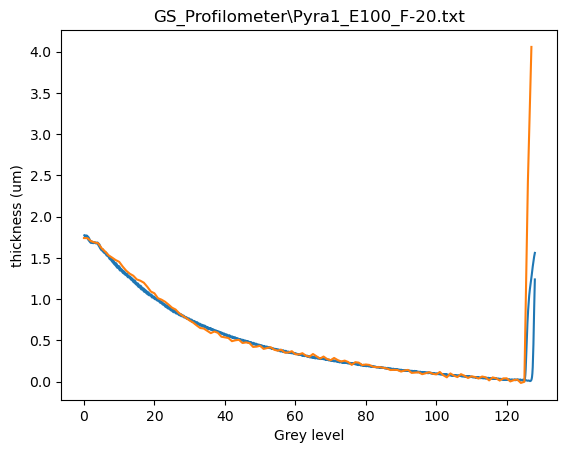

In [201]:
import csv
import numpy as np



filename = os.path.join(path, files[1])

print(filename)

filename = 'GS_Profilometer\\Pyra1_E100_F-20.txt'
# filename = 'GS_Profilometer\\Pyra2_E100_F-20.txt'

x,y = get_profile_pyramid(filename, ramp_decreasing=True, DEBUG_PLOTS=False)
gs, y_gs = greylevel_interpolation(x, y)
plt.figure()
plt.title(filename)


plt.plot(x,y, label='original')
plt.plot(gs, y_gs, label='interpolated')

plt.xlabel('Grey level')
plt.ylabel('thickness (um)')

# Save the figure with the same filename but with a .png extension
save_filename = os.path.splitext(filename)[0] + '.png'
plt.savefig(save_filename)



# Save the interpolated values to a CSV file
csv_filename = os.path.splitext(filename)[0] + '_greylevels.csv'
data = np.column_stack((gs, y_gs))
header = '#greylevel,thickness'
np.savetxt(csv_filename, data, delimiter=',', header=header, comments='', fmt='%d,%0.4f')



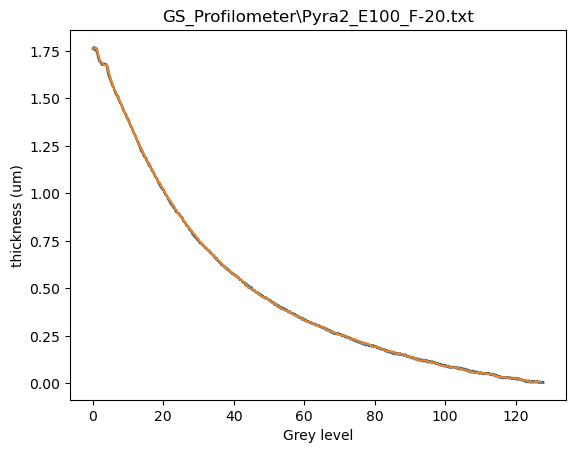

In [202]:

filename = 'GS_Profilometer\\Pyra2_E100_F-20.txt'

x,y = get_profile_pyramid(filename, ramp_decreasing=False, DEBUG_PLOTS=False)
gs, y_gs = greylevel_interpolation(x, y)

plt.figure()
plt.title(filename)
plt.plot(x,y, label='original')
plt.plot(gs, y_gs, label='interpolated')

plt.xlabel('Grey level')
plt.ylabel('thickness (um)')

# Save the figure with the same filename but with a .png extension
save_filename = os.path.splitext(filename)[0] + '.png'
plt.savefig(save_filename)


# Save the interpolated values to a CSV file
csv_filename = os.path.splitext(filename)[0] + '_greylevels.csv'
data = np.column_stack((gs, y_gs))
header = '#greylevel,thickness'
np.savetxt(csv_filename, data, delimiter=',', header=header, comments='', fmt='%d,%0.4f')



[-138.52252816 -138.32227785 -138.12202753 ...  755.19461827  755.39486859
  755.5951189 ]


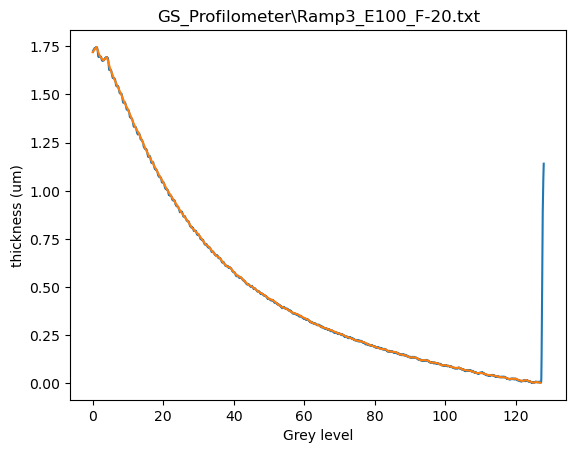

In [203]:

filename = 'GS_Profilometer\\Ramp3_E100_F-20.txt'

x,y = get_profile_ramp(filename, DEBUG_PLOTS=False)
gs, y_gs = greylevel_interpolation(x, y)
plt.figure()

plt.title(filename)
plt.plot(x,y, label='original')
plt.plot(gs, y_gs, label='interpolated')

plt.xlabel('Grey level')
plt.ylabel('thickness (um)')

# Save the figure with the same filename but with a .png extension
save_filename = os.path.splitext(filename)[0] + '.png'
plt.savefig(save_filename)



# Save the interpolated values to a CSV file
csv_filename = os.path.splitext(filename)[0] + '_greylevels.csv'
data = np.column_stack((gs, y_gs))
header = '#greylevel,thickness'
np.savetxt(csv_filename, data, delimiter=',', header=header, comments='', fmt='%d,%0.4f')
# header = 'greylevel,thickness'
# np.savetxt(csv_filename, data, delimiter=',', header=header, comments='')


GS_profilometer\Pyra1_E100_F-20_greylevels.csv
GS_profilometer\Pyra2_E100_F-20_greylevels.csv
GS_profilometer\Ramp3_E100_F-20_greylevels.csv


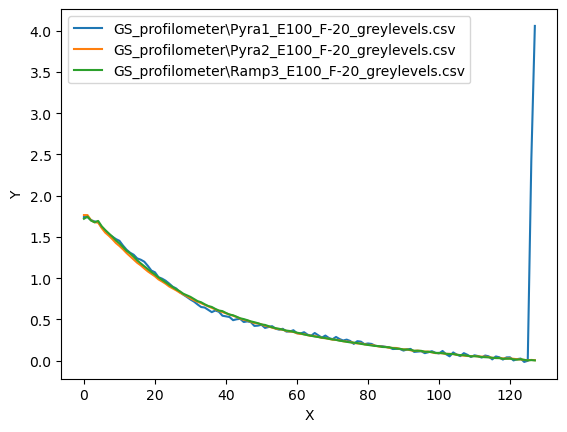

In [204]:


# Define the path to the directory containing the CSV files
path = "GS_profilometer\\"

# Get a list of all CSV files in the directory
csv_files = glob.glob(path + "*.csv")

# Iterate over each CSV file
for file in csv_files:
    print (file)
    # Load the data from the CSV file using np.loadtxt
    data = np.loadtxt(file, delimiter=",")

    # Extract the x and y values from the data
    x = data[:, 0]
    y = data[:, 1]


    
    # Plot the data
    plt.plot(x, y, label=file)

# Add labels and legend to the plot
plt.xlabel("grey level")
plt.ylabel("thickness")
plt.legend()

# Show the plot
plt.show()


GS_profilometer\Pyra1_E100_F-20_greylevels.csv
GS_profilometer\Pyra2_E100_F-20_greylevels.csv
GS_profilometer\Ramp3_E100_F-20_greylevels.csv


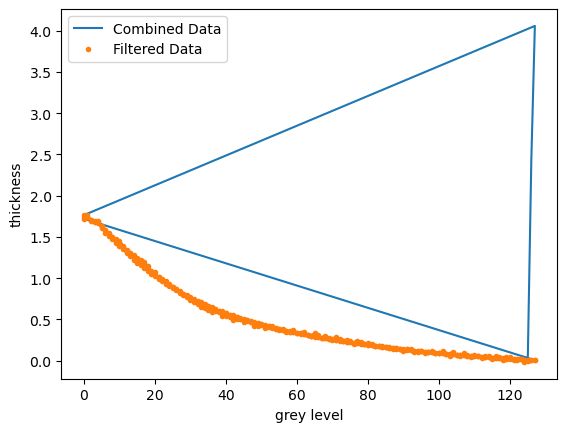

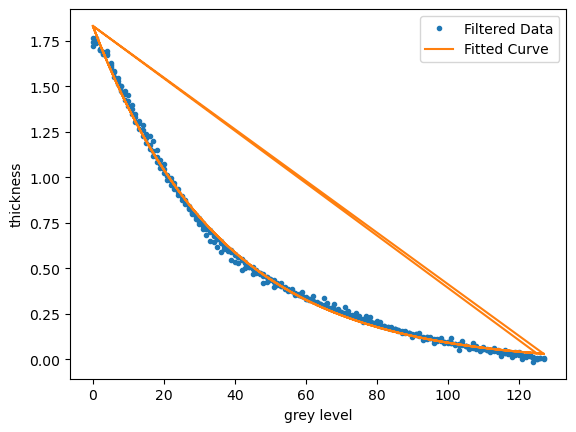

Root Mean Squared Error (RMSE): 0.0237397660668061
Fit data saved to fit_data.csv with RMSE as a comment.


In [228]:
from scipy.optimize import curve_fit
# Define the path to the directory containing the CSV files
path = "GS_profilometer\\"

# Get a list of all CSV files in the directory
csv_files = glob.glob(path + "*.csv")

# Initialize empty arrays to store the combined x and y values
combined_x = np.array([])
combined_y = np.array([])

# Iterate over each CSV file
for file in csv_files:
    print(file)
    # Load the data from the CSV file using np.loadtxt
    data = np.loadtxt(file, delimiter=",")

    # Extract the x and y values from the data
    x = data[:, 0]
    y = data[:, 1]

    # Append the x and y values to the combined arrays
    combined_x = np.append(combined_x, x)
    combined_y = np.append(combined_y, y)

# Plot the combined data
plt.plot(combined_x, combined_y, label="Combined Data")

### Filter out outliers

# Calculate the z-scores for the combined data
z_scores = (combined_y - np.mean(combined_y)) / np.std(combined_y)

# Define a threshold for outlier detection (e.g., z-score > 3)
threshold = 3

# Filter out the outliers based on the threshold
filtered_x = combined_x[z_scores <= threshold]
filtered_y = combined_y[z_scores <= threshold]



# Plot the filtered data
plt.plot(filtered_x, filtered_y, '.', label="Filtered Data")





# Add labels and legend to the plot
plt.xlabel("grey level")
plt.ylabel("thickness")
plt.legend()

# Show the plot
plt.show()


# Define the exponential function
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c



# Fit the filtered data to the exponential function using curve fit
popt, pcov = curve_fit(exponential_func, filtered_x, filtered_y)

# Extract the optimized parameters
a_opt, b_opt, c_opt = popt

# Generate the fitted curve using the optimized parameters
fitted_y = exponential_func(filtered_x, *popt)

# Plot the filtered data and the fitted curve
plt.plot(filtered_x, filtered_y, '.', label="Filtered Data")
plt.plot(filtered_x, fitted_y, label="Fitted Curve")

# Add labels and legend to the plot
plt.xlabel("grey level")
plt.ylabel("thickness")
plt.legend()

# Show the plot
plt.show()

# Calculate the residuals between the fitted curve and the filtered data
residuals = filtered_y - fitted_y

# Calculate the mean squared error (MSE)
mse = np.mean(residuals**2)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Print the RMSE
print("Root Mean Squared Error (RMSE):", rmse)

# Define the output file path
output_file = "fit_data.csv"

# Combine the filtered x and fitted y values into a single array
fit_data = np.column_stack((filtered_x, fitted_y))

# Add the RMSE as a comment in the header of the CSV file
header = f"# Root Mean Squared Error (RMSE): {rmse}\n"
header = '#greylevel,thickness\n#Root Mean Squared Error (RMSE): {rmse}'

# Save the fit data to the output file
np.savetxt(output_file, fit_data, delimiter=",", header=header, comments="", fmt='%d,%0.4f')

# Print a message to confirm the save operation
print(f"Fit data saved to {output_file} with RMSE as a comment.")



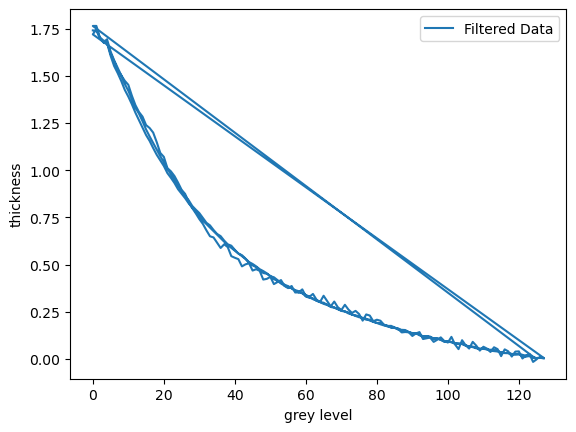

[-138.52252816 -138.32227785 -138.12202753 ...  755.19461827  755.39486859
  755.5951189 ]


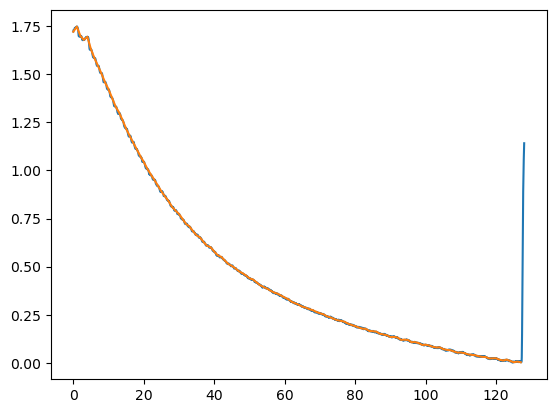

In [144]:



x,y = get_profile_ramp(filename, )


gs, y_gs = greylevel_interpolation(x, y)

plt.plot(x,y)
plt.plot(gs, y_gs)

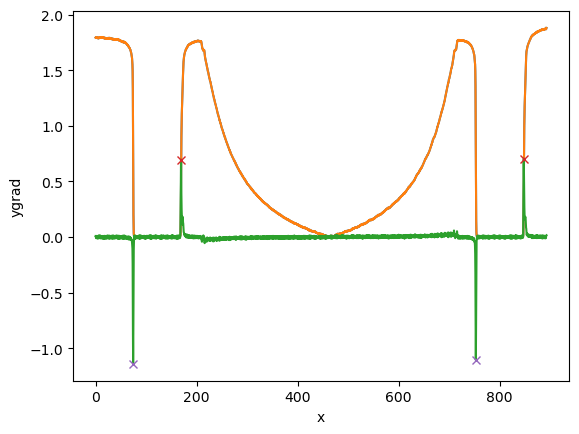

2317    0.003719
2318    0.004400
2319    0.005927
2320    0.007577
2321    0.008076
          ...   
4462    1.868200
4463    1.870370
4464    1.873310
4465    1.876600
4466    1.879960
Name: Normal, Length: 2150, dtype: float64


(800.5, 800.5)

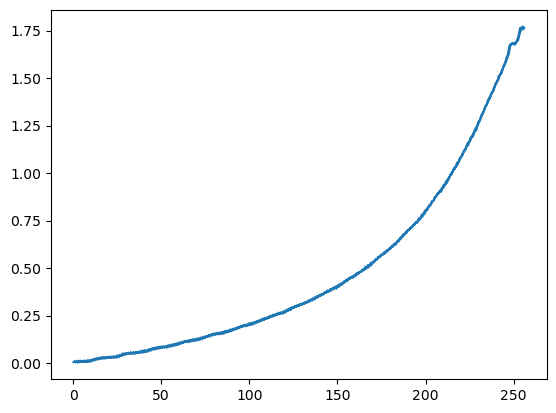

In [ ]:
x,y = parse_profilometer_xy_data(filename)
plt.plot(x,y)



ygrad = np.gradient(y,x)

peaks, _ = find_peaks(ygrad, prominence=0.5)
valleys, _ = find_peaks(-ygrad, prominence=0.5)
plt.plot(x, y)
plt.plot(x, ygrad)
plt.plot(x[peaks], ygrad[peaks], "x")
plt.plot(x[valleys], ygrad[valleys], "x")
plt.xlabel('x')
plt.ylabel('ygrad')
plt.show()

# determine the left and right coordinates of the peaks


fiducial_left_centroid = np.mean([x[peaks[0]], x[valleys[0]]])
fiducial_right_centroid = np.mean([x[peaks[-1]], x[valleys[-1]]])


plt.figure()


greyscale_step_width = 2
greylevels = 128
distance_between_fiducial_centroids = 680

distance_pyramid_halfwidth = greyscale_step_width*greylevels

stylus_tip_offset = 2


x = (x - fiducial_left_centroid) * (distance_between_fiducial_centroids / (fiducial_right_centroid-fiducial_left_centroid))
# normalized_y = (y - np.min(y)) * (780 / (right_coordinate - left_coordinate))

x = x-distance_between_fiducial_centroids/2-stylus_tip_offset
data_start = 0
data_end = data_start + 512

# Extract y values where x is between data_start and data_end
selected_y = y[(x >= data_start) & (x <= data_end)]

# Print the selected y values
print(selected_y)

# Truncate x and y where x < distance_pyramid_halfwidth
x_truncated = x[np.abs(x) < distance_pyramid_halfwidth]
y_truncated = y[np.abs(x) < distance_pyramid_halfwidth]




plt.plot(np.abs(x_truncated), y_truncated)

fiducial_right_centroid, fiducial_right_centroid



In [90]:
x[x < distance_pyramid_halfwidth]

array([-462.03329895, -461.83291587, -461.63253278, ...,  255.53852954,
        255.73891263,  255.93929571])

In [ ]:


data_start = 0
data_end = data_start + 512

# Extract y values where x is between data_start and data_end
selected_y = y[(x >= data_start) & (x <= data_end)]

# Print the selected y values
print(selected_y)

# plt.plot(x,y)
plt.plot(np.abs(x),y)

fiducial_right_centroid,fiducial_right_centroid


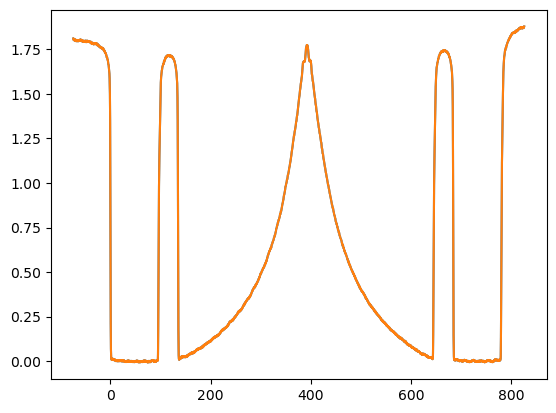

In [71]:
x = (x - left_coordinate) * (780 / (right_coordinate - left_coordinate))
# normalized_y = (y - np.min(y)) * (780 / (right_coordinate - left_coordinate))
data_start = 134
data_end = data_start + 512

# Extract y values where x is between data_start and data_end
selected_y = y[(x >= data_start) & (x <= data_end)]

# Print the selected y values
print(selected_y)

plt.plot(selected_y)

plt.plot(x, y)
plt.plot(x, y)

1034    1.430460
1035    1.354850
1036    1.239070
1037    1.075840
1038    0.873176
          ...   
3569    0.609739
3570    0.710448
3571    0.796253
3572    0.869483
3573    0.934080
Name: Normal, Length: 2540, dtype: float64


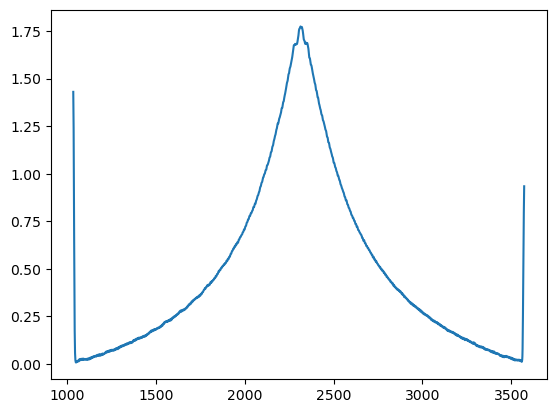

In [72]:
data_start = 134
data_end = data_start + 512

# Extract y values where x is between data_start and data_end
selected_y = y[(x >= data_start) & (x <= data_end)]

# Print the selected y values
print(selected_y)

plt.plot(selected_y)


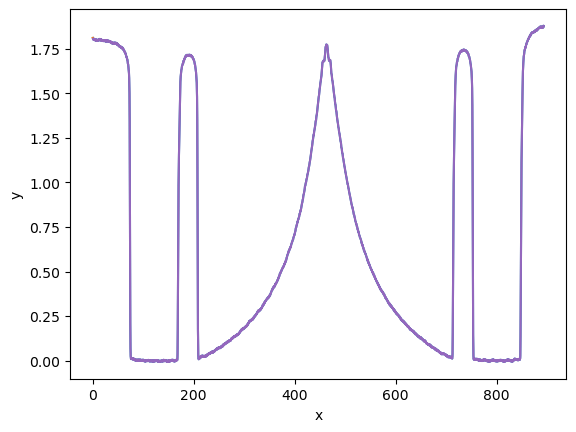

1304

In [43]:
def detect_flat_regions(x, y, threshold):
    # Calculate the differences between consecutive y values
    dy = np.diff(y)
    dy = np.gradient([x,y])
    
    # Find the indices where the differences are below the threshold
    flat_region_indices = np.where(np.abs(dy) <= threshold)[0]
    
    # Split the x and y values into separate regions based on the flat region indices
    regions = []
    start_index = 0
    for index in flat_region_indices:
        region = (x[start_index:index+1], y[start_index:index+1])
        regions.append(region)
        start_index = index + 1
    
    # Add the last region from the last flat region index to the end of the data
    last_region = (x[start_index:], y[start_index:])
    regions.append(last_region)
    
    return regions



plt.plot(x,y)

threshold = 0.001

flat_regions = detect_flat_regions(x, y, threshold)
for region in flat_regions:
    region_x, region_y = region
    plt.plot(region_x, region_y)


plt.xlabel('x')
plt.ylabel('y')
plt.show()
len(flat_regions)


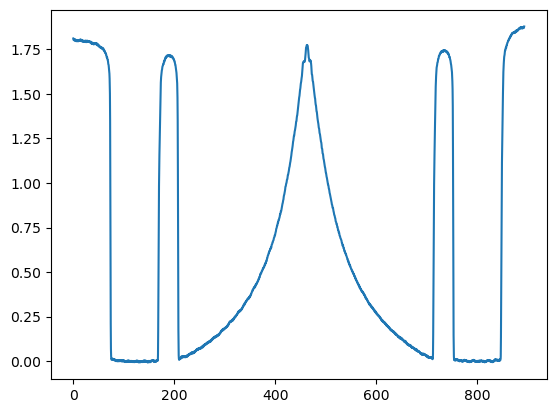

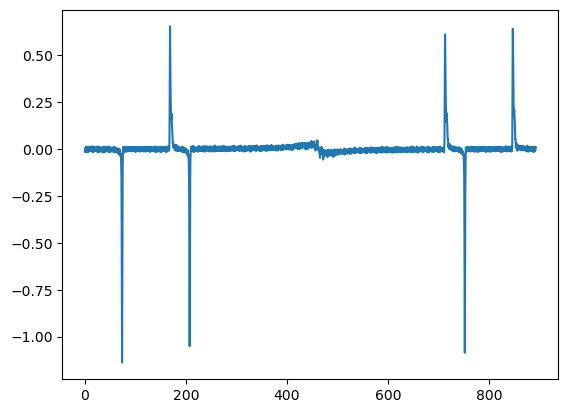

In [50]:
ygrad = np.gradient(y,x)

plt.plot(x,y)
plt.figure()
plt.plot(x,ygrad)



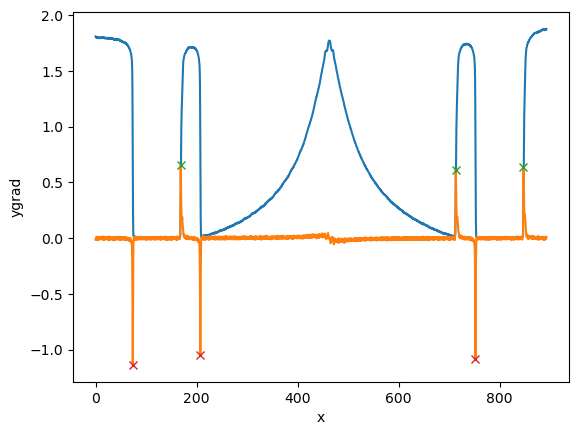

(73.60000000000001, 847.4000000000001)

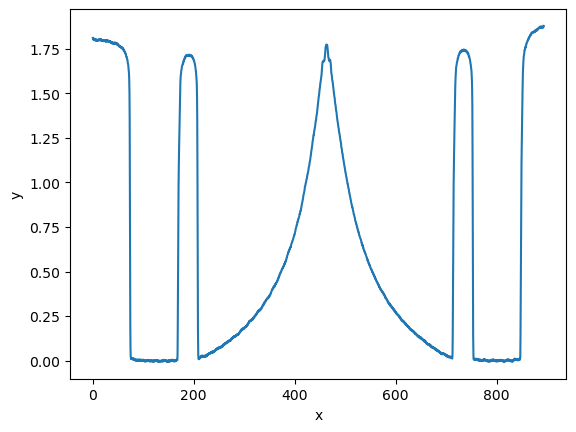

[(array([0.000e+00, 2.000e-01, 4.000e-01, ..., 8.926e+02, 8.928e+02,
         8.930e+02]),
  1       1.81099
  2       1.80825
  3       1.80513
  4       1.80245
  5       1.80187
           ...   
  4462    1.87000
  4463    1.87118
  4464    1.87374
  4465    1.87616
  4466    1.87833
  Name: Normal, Length: 4466, dtype: float64)]

In [24]:
def detect_regions(x, y, threshold):
    # Calculate the differences between consecutive x and y values
    dx = np.diff(x)
    dy = np.diff(y)
    
    # Find the indices where the differences exceed the threshold
    sharp_variation_indices = np.where((np.abs(dx) > threshold) | (np.abs(dy) > threshold))[0]
    
    # Split the x and y values into separate regions based on the sharp variation indices
    regions = []
    start_index = 0
    for index in sharp_variation_indices:
        region = (x[start_index:index+1], y[start_index:index+1])
        regions.append(region)
        start_index = index + 1
    
    # Add the last region from the last sharp variation index to the end of the data
    last_region = (x[start_index:], y[start_index:])
    regions.append(last_region)
    
    return regions
# x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# y = np.array([1, 1, 1, 2, 2, 2, 3, 3, 3, 1])
threshold = 0.5

regions = detect_regions(x, y, threshold)
for region in regions:
    region_x, region_y = region
    plt.plot(region_x, region_y)

plt.xlabel('x')
plt.ylabel('y')
plt.show()
regions